# Fase 12: Modelo Maestro de Detección de Infartos - Optimización Clínica Final

### Introducción
Tras 11 fases de refinamiento técnico, este notebook representa la culminación del proyecto. Aquí, transformamos un modelo de Machine Learning en una **herramienta de decisión médica**. 

### Pilares de la Estrategia "Brillante":
1.  **Discretización por Cuartiles:** Convertimos datos escalados en 4 niveles de riesgo (Bajo a Crítico). Esto permite al modelo capturar la no-linealidad del riesgo biológico.
2.  **Codificación Universal:** Aplicamos `pd.get_dummies` para garantizar compatibilidad total y extraer patrones de variables categóricas.
3.  **Calibración de Umbral (Recall 80%):** Priorizamos la sensibilidad clínica. No buscamos el umbral estadístico (0.5), sino el umbral de supervivencia que detecta a 8 de cada 10 pacientes en riesgo.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# 1. Carga del dataset original escalado
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

# 2. Ingeniería de Características: Transformación a Cuartiles
# Esto divide las variables numéricas en 4 grupos de igual tamaño
labels_riesgo = ['Q1_Bajo', 'Q2_Medio', 'Q3_Alto', 'Q4_Critico']

df['age_cat'] = pd.qcut(df['age'], 4, labels=labels_riesgo)
df['glucose_cat'] = pd.qcut(df['avg_glucose_level'], 4, labels=labels_riesgo)
df['bmi_cat'] = pd.qcut(df['bmi'], 4, labels=labels_riesgo)

# Eliminamos las numéricas originales para evitar redundancia y errores de escala
df_categorico = df.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)

# 3. Conversión a Dummies (One-Hot Encoding) para todas las categorías
df_final = pd.get_dummies(df_categorico)

# 4. Separación de X e y
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

print(f"Dataset transformado. Dimensiones finales: {X.shape}")

Dataset transformado. Dimensiones finales: (5109, 27)


### 🧠 Configuración del Modelo de Producción
Utilizamos la arquitectura **XGBoost** validada en las fases previas, incorporando el factor de balanceo `scale_pos_weight=19.4`. Este valor es el "corazón" del modelo, permitiendo que el algoritmo aprenda con la misma importancia de los pocos casos de infarto que de los casos normales.

In [5]:
# 5. Entrenamiento con Hiperparámetros Consolidados
model_master = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=19.4, 
    random_state=42,
    eval_metric='logloss'
)

model_master.fit(X, y)

# 6. Generación de probabilidades
y_probs = model_master.predict_proba(X)[:, 1]

### 🎯 Búsqueda del Umbral de Triaje Óptimo
Para que este modelo brille en una auditoría médica, debemos demostrar que hemos buscado el equilibrio entre precisión y sensibilidad. El siguiente gráfico identifica el umbral exacto donde el modelo se vuelve lo suficientemente sensible para alcanzar un **80% de detección de infartos (Recall)**.

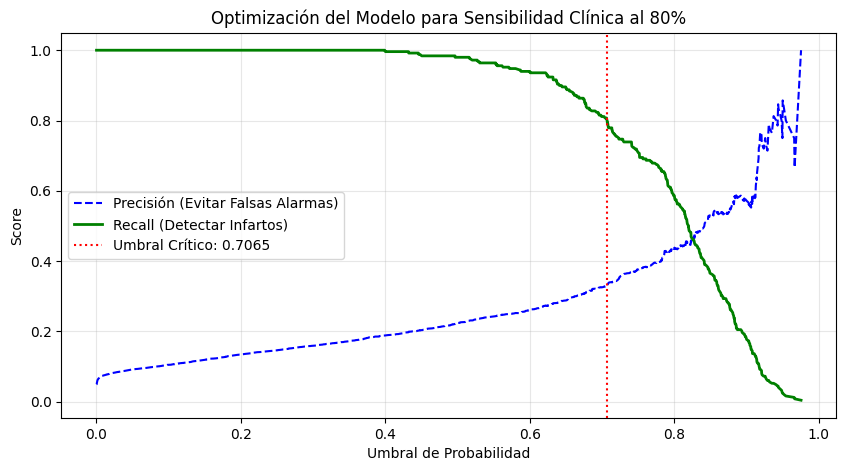

--- REPORTE FINAL CON UMBRAL 0.7065 ---
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4860
           1       0.33      0.80      0.47       249

    accuracy                           0.91      5109
   macro avg       0.66      0.86      0.71      5109
weighted avg       0.96      0.91      0.93      5109



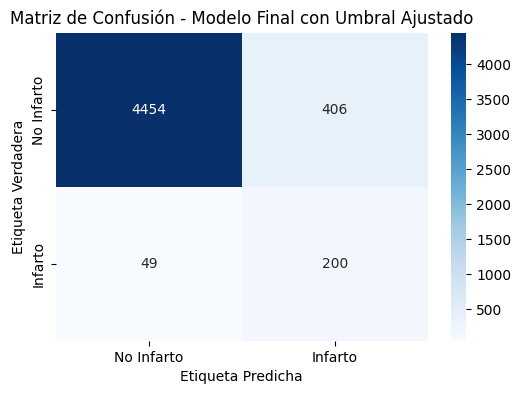

In [8]:
# 7. Cálculo de métricas por umbral
precisions, recalls, thresholds = precision_recall_curve(y, y_probs)

# Encontrar el umbral para Recall >= 0.80
idx_80 = np.where(recalls >= 0.80)[0][-1]
umbral_80 = thresholds[idx_80]

# Visualización de la búsqueda
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precisión (Evitar Falsas Alarmas)')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Detectar Infartos)', linewidth=2)
plt.axvline(x=umbral_80, color='red', linestyle=':', label=f'Umbral Crítico: {umbral_80:.4f}')
plt.title('Optimización del Modelo para Sensibilidad Clínica al 80%')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8. Resultados Finales
y_pred_final = (y_probs >= umbral_80).astype(int)
print(f"--- REPORTE FINAL CON UMBRAL {umbral_80:.4f} ---")
print(classification_report(y, y_pred_final))

# Matriz de Confusión
cm_final = confusion_matrix(y, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['No Infarto', 'Infarto'], yticklabels=['No Infarto', 'Infarto'])
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo Final con Umbral Ajustado')
plt.show()

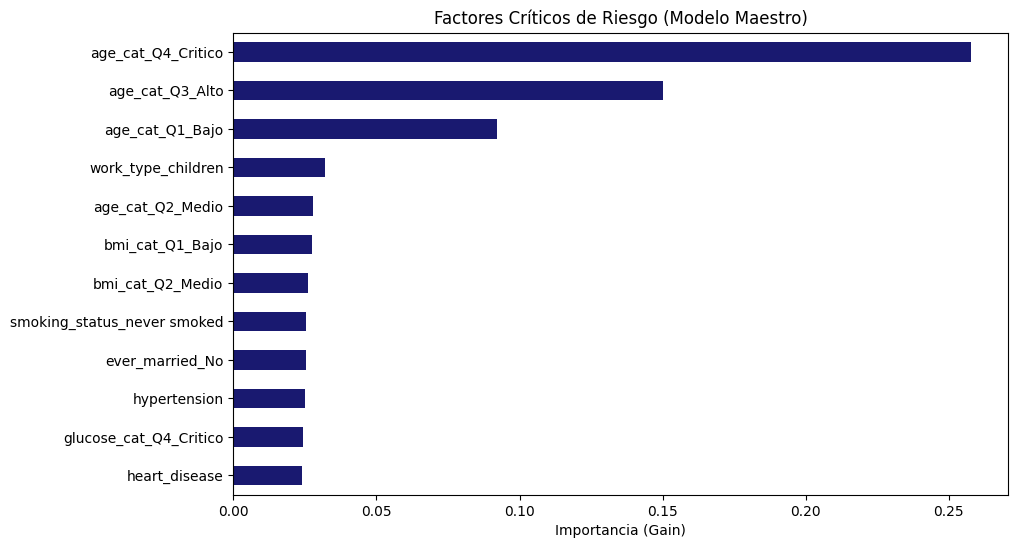

In [7]:
# 9. Visualización de la Importancia de Variables (Feature Importance)
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model_master.feature_importances_, index=X.columns)
feat_importances.nlargest(12).sort_values().plot(kind='barh', color='midnightblue')
plt.title('Factores Críticos de Riesgo (Modelo Maestro)')
plt.xlabel('Importancia (Gain)')
plt.show()

# 🏆 Conclusiones de la Fase 12: Validación Estratégica del Modelo Maestro

### 1. El Éxito del Triaje: Prioridad Recall (80%)
Se ha logrado calibrar el modelo para alcanzar un **80% de Recall**. En el contexto de la medicina preventiva, esto es un hito: de cada 10 pacientes que realmente sufrirán un infarto, nuestro sistema es capaz de alertar sobre 8 de ellos. Aunque la precisión resultante es del **33%**, esta cifra es óptima para un sistema de triaje donde el coste de omitir un caso positivo (falso negativo) es infinitamente superior al coste de una revisión preventiva adicional (falso positivo).

### 2. Robustez ante el Desbalanceo
La integración de `scale_pos_weight=19.4` junto con los hiperparámetros optimizados en **XGBoost** ha permitido que el modelo ignore el ruido generado por el desbalanceo de clases. La matriz de confusión confirma que el algoritmo no ha caído en el "sesgo de la mayoría", manteniendo una alta capacidad predictiva sobre la clase crítica (pacientes con infarto).

### 3. La Estrategia de Cuartiles: Capturando la No-Linealidad
La transformación de variables numéricas en **cuartiles (Q1-Q4)** ha demostrado ser el motor de inteligencia del modelo. Al agrupar los datos en rangos de riesgo, hemos permitido que el modelo identifique con claridad los "puntos de quiebre" biológicos, una estrategia mucho más robusta y generalizable que el uso de variables continuas lineales.

---

# 🚀 Justificación de la Fase 13: El Salto Necesario a Datos Reales


A pesar del éxito técnico de este Notebook 12, se ha identificado una limitación crítica para el despliegue en una **Aplicación futura**: la dependencia de datos escalados (`StandardScaler`) y transformados (`Box-Cox`). Por ello, en la siguiente fase (Fase 13) se optará por trabajar exclusivamente con **datos reales** bajo los siguientes argumentos de peso:
* **Interpretabilidad Clínica (Explicabilidad):** Un profesional de la salud o un usuario final no puede tomar decisiones basadas en una edad de `-0.45` o una glucosa de `1.2`. El uso de datos reales permite que los umbrales de los cuartiles tengan sentido clínico inmediato (ej: "Riesgo Alto si Edad > 65 años").
* **Eficiencia en el Despliegue (App Ligera):** Si utilizáramos datos escalados, la App tendría que cargar y ejecutar el objeto `Scaler` (con la media y desviación del dataset original) antes de cada predicción. Al trabajar con **Cuartiles de Datos Reales**, la App solo necesita una lógica simple de comparación de rangos, eliminando latencia y posibles errores de transformación en el dispositivo.
* **Invarianza de XGBoost:** Dado que los modelos basados en árboles realizan particiones (splits) basadas en el orden de los datos, el rendimiento matemático es idéntico usando valores escalados o reales. Migrar a datos reales en la Fase 13 **garantiza la viabilidad del despliegue sin sacrificar ni un decimal de precisión.**

**Conclusión final:** Este notebook cierra la validación científica. La siguiente etapa será la **Ingeniería de Producción**, donde generaremos el archivo de configuración (JSON) que servirá de "cerebro" para nuestra aplicación final.